# **Import Packages and Libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
train_logs = pd.read_csv('/content/train_logs.csv')
train_scores = pd.read_csv('/content/train_scores.csv')

<Axes: >

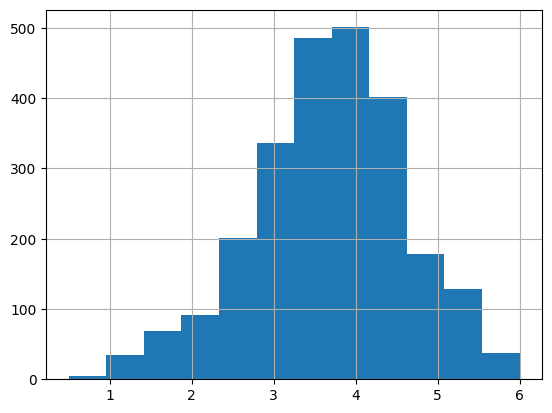

In [3]:
train_scores['score'].hist(bins=12)

In [4]:
train_scores.head(1000)['score'].value_counts()

4.0    201
3.5    189
4.5    173
3.0    141
2.5     75
5.0     75
5.5     48
2.0     36
1.5     29
6.0     15
1.0     14
0.5      4
Name: score, dtype: int64

In [5]:
df_train = train_logs

# **Data Preprocessing**

In [6]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # Total/ Mean
    total_duration = df.groupby('id')['action_time'].sum()
    total_events = df.groupby('id').size()
    final_word_count = df.groupby('id')['word_count'].last()
    mean_action_time = df.groupby('id')['action_time'].mean()
    total_activity_counts = df['activity'].value_counts()

    # Compute activity counts only for the relevant activities
    activity_counts = df[df['activity'].isin(['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste'])].pivot_table(index='id', columns='activity', aggfunc='size', fill_value=0)

    # Combine into a single DataFrame
    processed_df = pd.concat([total_duration, total_events, activity_counts, mean_action_time, final_word_count], axis=1)
    processed_df.columns = ['total_duration', 'total_events'] + activity_counts.columns.tolist() + ['mean_action_time', 'final_word_count']

    return processed_df

In [7]:
processed_train_df = preprocess(df_train).merge(train_scores, on="id", suffixes=(None, None))

In [8]:
processed_train_df

,id,total_duration,total_events,Input,Nonproduction,Paste,Remove/Cut,Replace,mean_action_time,final_word_count,score
0,001519c8,297243,2557,2010,120,0,417,7,116.246774,255,3.5
1,0022f953,275391,2454,1938,254,1,260,1,112.221271,320,3.5
2,0042269b,421201,4136,3515,175,0,439,7,101.837766,404,6.0
3,0059420b,189596,1556,1304,99,1,151,1,121.848329,206,2.0
4,0075873a,313702,2531,1942,72,0,517,0,123.943896,252,4.0
...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,499670,4739,3588,189,0,960,2,105.437856,273,3.5
2467,ffbef7e5,214221,2604,2395,148,0,60,1,82.266129,438,4.0
2468,ffccd6fd,231580,3063,2849,126,0,88,0,75.605615,201,1.5
2469,ffec5b38,289439,3242,2895,71,0,276,0,89.277915,413,5.0


In [9]:
cols = ['total_duration', 'total_events',
       'Input', 'Nonproduction',
       'Paste', 'Remove/Cut',
       'Replace', 'mean_action_time',
       'final_word_count',]

Plots for total_duration


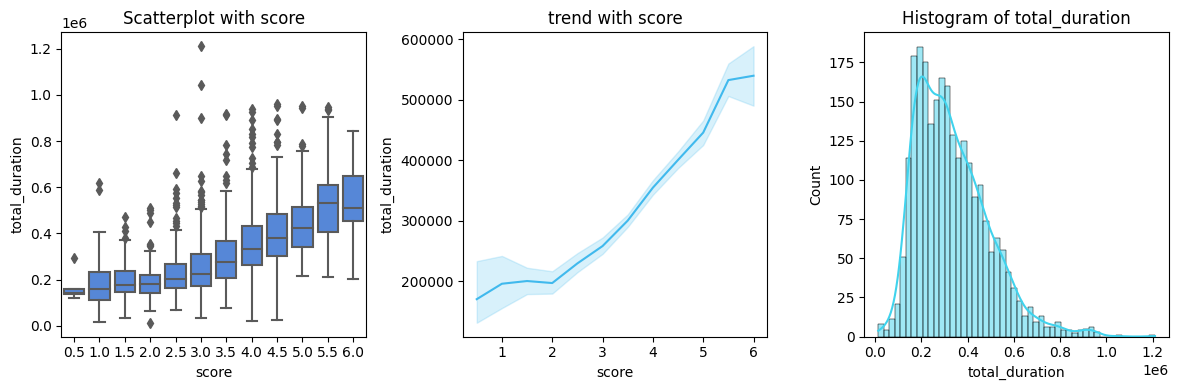

Plots for total_events


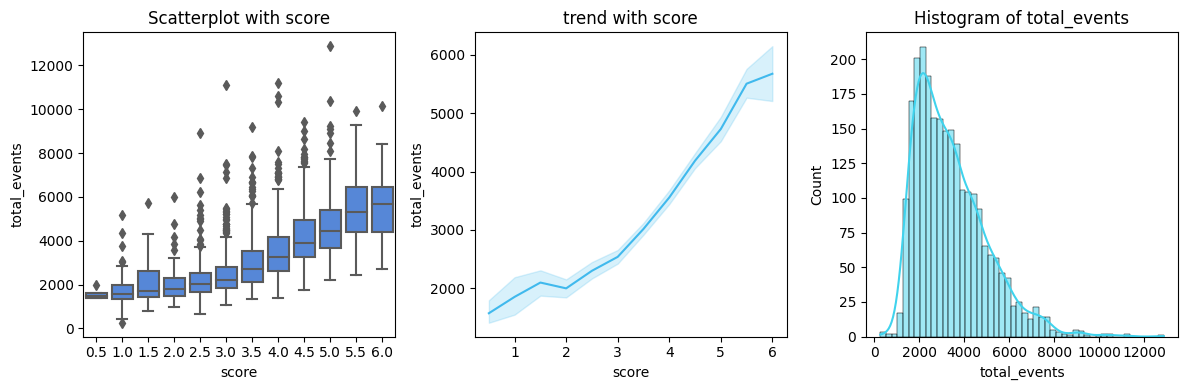

Plots for Input


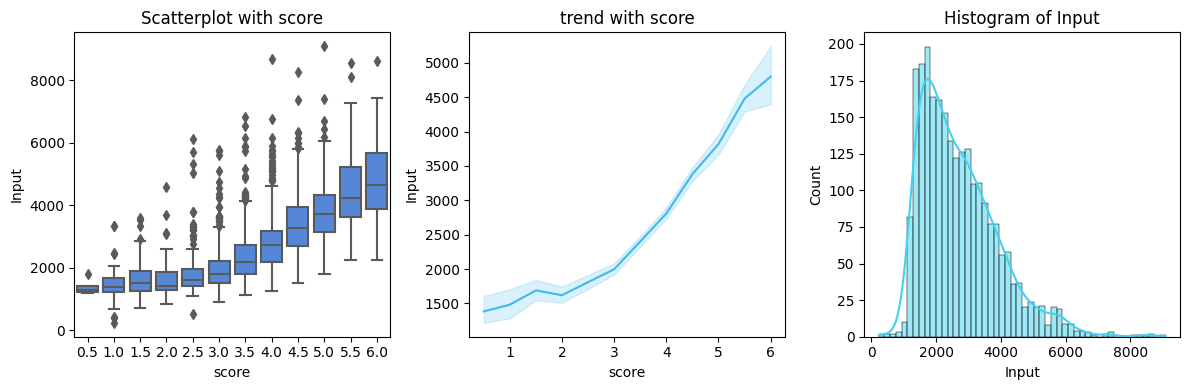

Plots for Nonproduction


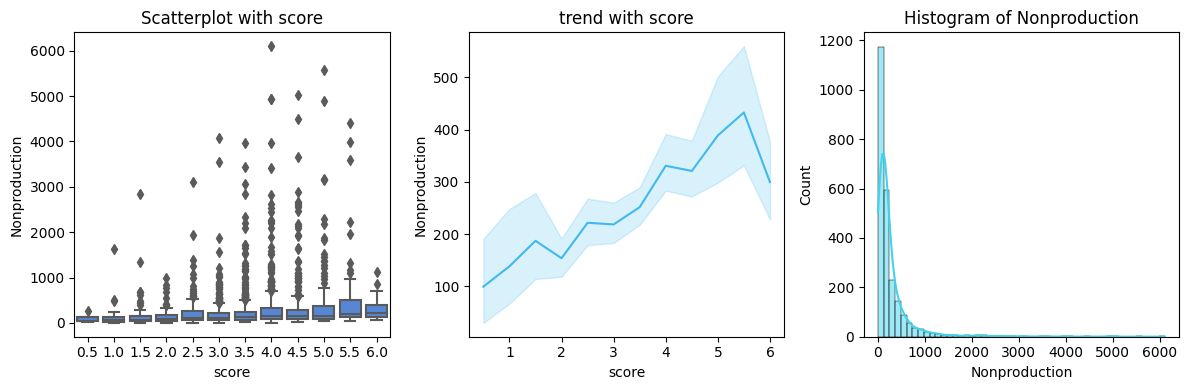

Plots for Paste


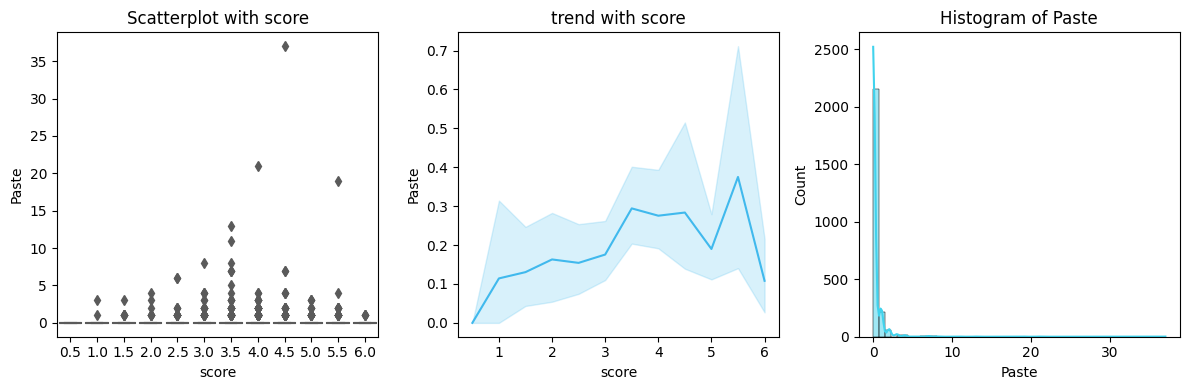

Plots for Remove/Cut


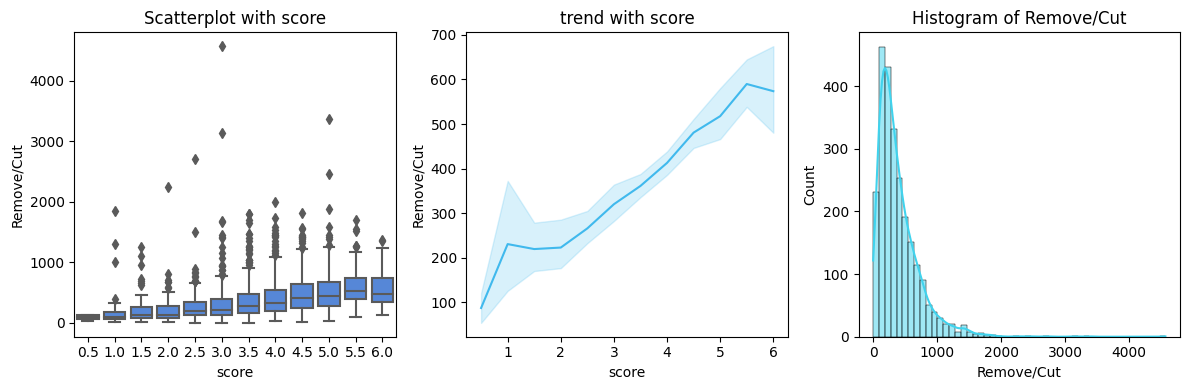

Plots for Replace


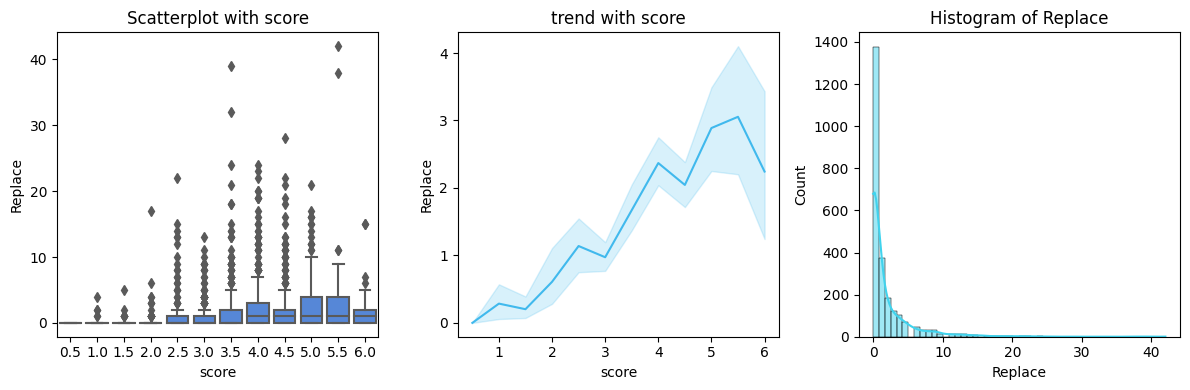

Plots for mean_action_time


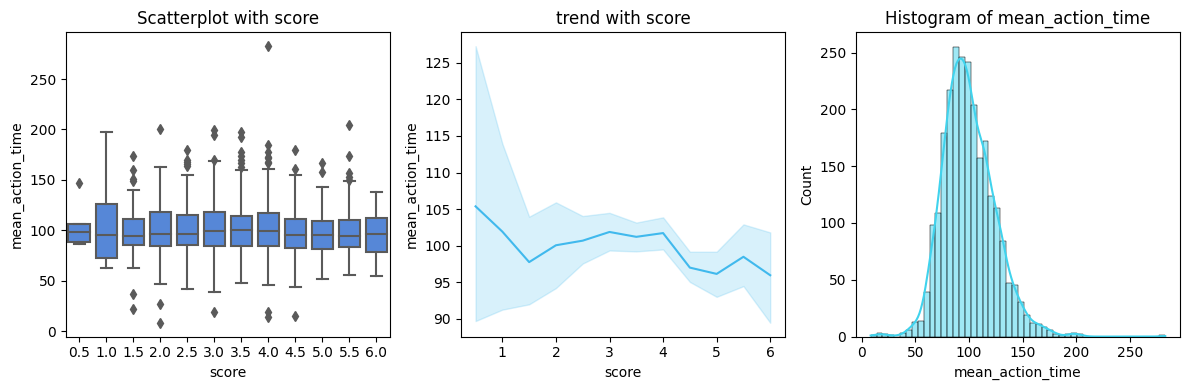

Plots for final_word_count


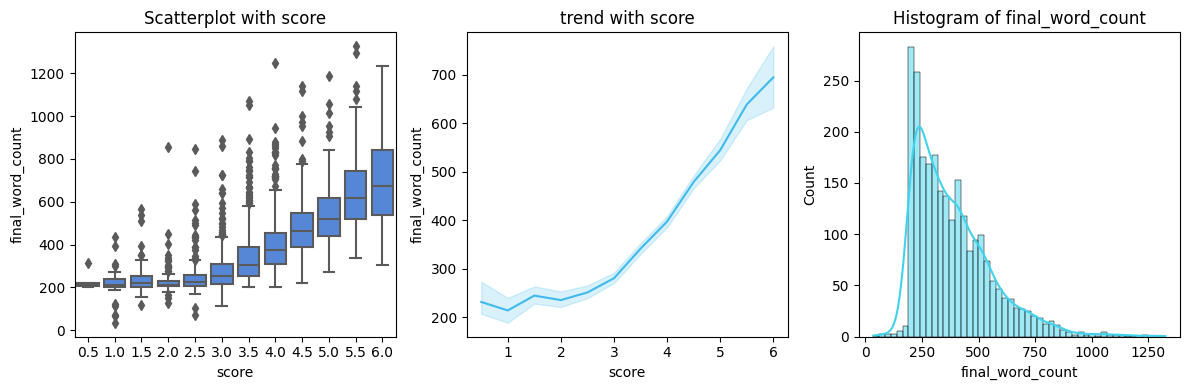

In [10]:
for col in cols:
    print(f'Plots for {col}')
    plt.figure(figsize=(12, 4))

    plt.subplot(1,3, 1)
    sns.boxplot(y=processed_train_df[col], x=processed_train_df['score'], color='#4082ed')
    plt.title("Scatterplot with score")

    plt.subplot(1, 3, 2)
    sns.lineplot(y=processed_train_df[col], x=processed_train_df['score'], color='#40b9ed')
    plt.title("trend with score")

    plt.subplot(1, 3, 3)
    sns.histplot(x=processed_train_df[col], bins=50, kde=True, color='#40d3ed')
    plt.title(f"Histogram of {col}")

    plt.tight_layout()
    plt.show()

In [11]:
# Drop id and split X and y
modeling_df = processed_train_df.drop(columns=['id'])
tX, tY = modeling_df.drop(columns=['score']), modeling_df['score']
training_columns = tX.columns

In [12]:
# Standard Scaler
scaler = StandardScaler()
tX_scaled = scaler.fit_transform(tX)

In [82]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(tX_scaled, tY, test_size=0.2, random_state=42)

In [14]:
X_train[0]

array([ 0.10134414, -0.44713748, -0.65234454, -0.34929211, -0.20151349,
        0.75826854, -0.49607963,  1.23332735, -0.8798958 ])

# **Modeling (From Scratch)**

***Default (no tuning)***

In [83]:
import random

In [84]:
class DecisionTree:
    def __init__(self, max_depth, min_samples_split):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self._predict_sample(x, self.root)
            predictions.append(prediction)
        return predictions

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return None

        best_split = self._find_best_split(X, y)
        if best_split is None:
            return None

        left_X, left_y, right_X, right_y = self._split_data(X, y, best_split)
        left_tree = self._build_tree(left_X, left_y, depth + 1)
        right_tree = self._build_tree(right_X, right_y, depth + 1)

        return Node(best_split['feature'], best_split['threshold'], left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_split = None
        best_gain = 0

        for feature in range(X.shape[1]):
            for threshold in X[:, feature]:
                left_y, right_y = self._split_labels(y, X[:, feature], threshold)
                gain = self._calculate_information_gain(left_y, right_y)
                if gain > best_gain:
                    best_split = {'feature': feature, 'threshold': threshold, 'gain': gain}
                    best_gain = gain

        return best_split

    def _split_data(self, X, y, split):
        feature = split['feature']
        threshold = split['threshold']

        left_X = X[X[:, feature] <= threshold]
        left_y = y[X[:, feature] <= threshold]

        right_X = X[X[:, feature] > threshold]
        right_y = y[X[:, feature] > threshold]

        return left_X, left_y, right_X, right_y

    def _split_labels(self, y, X_feat, threshold):
        left_y = y[X_feat <= threshold]
        right_y = y[X_feat > threshold]

        return left_y, right_y

    def _calculate_information_gain(self, y1, y2):
        p1 = len(y1) / len(y)
        p2 = len(y2) / len(y)

        entropy1 = self._calculate_entropy(y1)
        entropy2 = self._calculate_entropy(y2)

        return p1 * entropy1 + p2 * entropy2

    def _calculate_entropy(self, y):
        unique_values, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)

        entropy = -np.sum(probabilities * np.log2(probabilities))

        return entropy


In [85]:
class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

    def predict(self, x):
        if x[self.feature] <= self.threshold:
            if self.left is None:
                return np.mean(self.left_y)
            else:
                return self.left.predict(x)
        else:
            if self.right is None:
                return np.mean(self.right_y)
            else:
                return self.right.predict(x)

In [86]:
class RandomForestRegressor:
    def __init__(self, n_trees, max_depth, min_samples_split):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTree(self.max_depth, self.min_samples_split)
            tree.fit(X, y)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for x in X:
            tree_predictions = []
            for tree in self.trees:
                prediction = tree.predict(x)
                tree_predictions.append(prediction)

            mean_prediction = np.mean(tree_predictions)
            predictions.append(mean_prediction)

        return predictions

In [87]:
# Create the Random Forest regressor
rf = RandomForestRegressor(n_trees=100, max_depth=5, min_samples_split=2)

# Fit the model to the data
# rf.fit(X, y)

# Fit the model to the data
for i in range(rf.n_trees):
    tree = DecisionTree(rf.max_depth, rf.min_samples_split)
    tree.fit(X, y)
    rf.trees.append(tree)

    # Print training progress after each tree
    print("Tree", i + 1, "fitted")

Tree 1 fitted
Tree 2 fitted
Tree 3 fitted
Tree 4 fitted
Tree 5 fitted
Tree 6 fitted
Tree 7 fitted
Tree 8 fitted
Tree 9 fitted
Tree 10 fitted
Tree 11 fitted
Tree 12 fitted
Tree 13 fitted
Tree 14 fitted
Tree 15 fitted
Tree 16 fitted
Tree 17 fitted
Tree 18 fitted
Tree 19 fitted
Tree 20 fitted
Tree 21 fitted
Tree 22 fitted
Tree 23 fitted
Tree 24 fitted
Tree 25 fitted
Tree 26 fitted
Tree 27 fitted
Tree 28 fitted
Tree 29 fitted
Tree 30 fitted
Tree 31 fitted
Tree 32 fitted
Tree 33 fitted
Tree 34 fitted
Tree 35 fitted
Tree 36 fitted
Tree 37 fitted
Tree 38 fitted
Tree 39 fitted
Tree 40 fitted
Tree 41 fitted
Tree 42 fitted
Tree 43 fitted
Tree 44 fitted
Tree 45 fitted
Tree 46 fitted
Tree 47 fitted
Tree 48 fitted
Tree 49 fitted
Tree 50 fitted
Tree 51 fitted
Tree 52 fitted
Tree 53 fitted
Tree 54 fitted
Tree 55 fitted
Tree 56 fitted
Tree 57 fitted
Tree 58 fitted
Tree 59 fitted
Tree 60 fitted
Tree 61 fitted
Tree 62 fitted
Tree 63 fitted
Tree 64 fitted
Tree 65 fitted
Tree 66 fitted
Tree 67 fitted
Tree

In [87]:
y_pred = rf.predict(X_test)

In [53]:
# Calculate RMSE
def rmse(y_true, y_pred):
  squared_error = np.square(y_true - y_pred)  # Calculate squared differences
  mean_squared_error = np.mean(squared_error)  # Calculate mean squared error
  return np.sqrt(mean_squared_error)  # Take the square root to get RMSE

error = rmse(y_test, y_pred)
print(f"Root Mean Squared Error: {error}")

Root Mean Squared Error: 0.6617851584612607


In [54]:
# Calculate MAE
def mae(y_true, y_pred):
  absolute_errors = np.abs(y_true - y_pred)  # Calculate absolute differences
  mean_absolute_error = np.mean(absolute_errors)  # Calculate average absolute error
  return mean_absolute_error  # Return the MAE


error = mae(y_test, y_pred)
print(f"Mean Absolute Error: {error}")

Mean Absolute Error: 0.515959595959596


***Tuned model from scratch***

In [87]:
class LassoEstimator:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.coef_ = None

    def fit(self, X, y):
        # Implement L1 regularization using gradient descent
        learning_rate = 0.01
        max_iters = 1000
        w = np.zeros(X.shape[1])

        for _ in range(max_iters):
            predictions = X.dot(w)
            errors = y - predictions
            reg_term = 2 * self.alpha * np.where(w > 0, w, -w)  # apply L1 penalty

            gradient = -2 * errors.T.dot(X) + reg_term
            w -= learning_rate * gradient

        self.coef_ = w

    def predict(self, X):
        return X.dot(self.coef_)

In [87]:
class RandomForestRegressorWithSFM:
    def __init__(self, n_trees, max_depth, min_samples_split, selector_kwargs=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.selector = None

        # Pass optional keyword arguments to the selector
        if selector_kwargs is None:
            selector_kwargs = {}

    def fit(self, X, y):
        # Initialize and fit the SelectFromModel object
        self.selector = sklearn.feature_selection.SelectFromModel(**selector_kwargs)
        self.selector.fit(X, y)

        # Apply feature selection and use transformed data for tree fitting
        selected_features = self.selector.get_support()
        X_selected = X[:, selected_features]

        for _ in range(self.n_trees):
            tree = DecisionTree(self.max_depth, self.min_samples_split)
            tree.fit(X_selected, y)
            self.trees.append(tree)

            # Print training progress after each tree
            print("Tree", i + 1, "fitted")

    def predict(self, X):
        # Apply feature selection on new data
        X_selected = X[:, self.selector.get_support()]

        predictions = []
        for x in X_selected:
            tree_predictions = []
            for tree in self.trees:
                prediction = tree.predict(x)
                tree_predictions.append(prediction)

            mean_prediction = np.mean(tree_predictions)
            predictions.append(mean_prediction)

        return predictions

# Example usage
X = np.random.rand(100, 20)
y = np.random.rand(100)

In [88]:
model = RandomForestRegressorWithSFM(n_trees=100, max_depth=5, min_samples_split=2)
model.fit(X, y)

Tree 1 fitted
Tree 2 fitted
Tree 3 fitted
Tree 4 fitted
Tree 5 fitted
Tree 6 fitted
Tree 7 fitted
Tree 8 fitted
Tree 9 fitted
Tree 10 fitted
Tree 11 fitted
Tree 12 fitted
Tree 13 fitted
Tree 14 fitted
Tree 15 fitted
Tree 16 fitted
Tree 17 fitted
Tree 18 fitted
Tree 19 fitted
Tree 20 fitted
Tree 21 fitted
Tree 22 fitted
Tree 23 fitted
Tree 24 fitted
Tree 25 fitted
Tree 26 fitted
Tree 27 fitted
Tree 28 fitted
Tree 29 fitted
Tree 30 fitted
Tree 31 fitted
Tree 32 fitted
Tree 33 fitted
Tree 34 fitted
Tree 35 fitted
Tree 36 fitted
Tree 37 fitted
Tree 38 fitted
Tree 39 fitted
Tree 40 fitted
Tree 41 fitted
Tree 42 fitted
Tree 43 fitted
Tree 44 fitted
Tree 45 fitted
Tree 46 fitted
Tree 47 fitted
Tree 48 fitted
Tree 49 fitted
Tree 50 fitted
Tree 51 fitted
Tree 52 fitted
Tree 53 fitted
Tree 54 fitted
Tree 55 fitted
Tree 56 fitted
Tree 57 fitted
Tree 58 fitted
Tree 59 fitted
Tree 60 fitted
Tree 61 fitted
Tree 62 fitted
Tree 63 fitted
Tree 64 fitted
Tree 65 fitted
Tree 66 fitted
Tree 67 fitted
Tree

In [87]:
y_pred = model.predict(X)

In [67]:
# Calculate RMSE
def rmse(y_true, y_pred):
  squared_error = np.square(y_true - y_pred)  # Calculate squared differences
  mean_squared_error = np.mean(squared_error)  # Calculate mean squared error
  return np.sqrt(mean_squared_error)  # Take the square root to get RMSE

error = rmse(y_test, y_pred)
print(f"Root Mean Squared Error: {error}")

Root Mean Squared Error: 0.6405390184167224


In [69]:
# Calculate MAE
def mae(y_true, y_pred):
  absolute_errors = np.abs(y_true - y_pred)  # Calculate absolute differences
  mean_absolute_error = np.mean(absolute_errors)  # Calculate average absolute error
  return mean_absolute_error  # Return the MAE


error = mae(y_test, y_pred)
print(f"Mean Absolute Error: {error}")

Mean Absolute Error: 0.509421464577909


# **Modeling (Sklearn)**

In [15]:
# random forest
clf = RandomForestRegressor(n_estimators=50)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50)

In [16]:
y_pred = clf.predict(X_test)

In [17]:
# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.647433628281929


In [18]:
# Calculate RMSE
mae = mean_absolute_error(y_test, y_pred)
# rmae = np.sqrt(mae)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.5045858585858586


In [19]:
# Create a random forest regressor
rf = RandomForestRegressor()

In [20]:
# Create a SelectFromModel object and specify the random forest regressor as the estimator
selector = SelectFromModel(estimator=rf, max_features=5)

In [21]:
# Create a pipeline
pipeline = Pipeline([
    ('selector', selector),
    ('random_forest_regressor', RandomForestRegressor())
])

In [22]:
# Define the grid of hyperparameters to tune
param_grid = {
    'random_forest_regressor__n_estimators': [100, 200, 300],
    'random_forest_regressor__max_depth': [3, 5, 7]
}

In [23]:
# Create a GridSearchCV object and specify the pipeline as the estimator
gscv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=8)

In [24]:
# Fit the GridSearchCV object to the training data
gscv.fit(X_train, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(),
                                                        max_features=5)),
                                       ('random_forest_regressor',
                                        RandomForestRegressor())]),
             param_grid={'random_forest_regressor__max_depth': [3, 5, 7],
                         'random_forest_regressor__n_estimators': [100, 200,
                                                                   300]})

In [25]:
# Select the best model from the GridSearchCV object
best_model = gscv.best_estimator_

In [26]:
# Evaluate the best model on the test data
y_pred = best_model.predict(X_test).clip(0.5, 6)

In [27]:
# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.6316414666340646


In [28]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.4894197432285766


# **Test Of Statistical Significance (From Scratch)**

 ***t-statistic & p-value***

In [56]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
n_folds = 5

# Define the range of random states you want to explore
random_states = range(40, 45)  # Includes 40, 41, 42, 43, and 44

# Initialize empty dictionaries to store results for each random state
p_values = {}
t_statistics = {}

In [57]:
# Loop through each random state
for random_state in random_states:
    # Create k-fold cross-validation splits with the current random state
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Initialize empty lists for the current random state
    fold_p_values = []
    fold_t_statistics = []

    # Iterate through each fold
    for train_index, test_index in kf.split(tX_scaled):
        # Get train and test data for the current fold
        X_train_fold, X_test_fold = tX_scaled[train_index], tX_scaled[test_index]
        y_train_fold, y_test_fold = tY[train_index], tY[test_index]

        # Create and train the pipeline with the current random state
        rf = RandomForestRegressor(random_state=random_state)
        selector = SelectFromModel(estimator=rf, max_features=5)
        pipeline = Pipeline([('selector', selector), ('random_forest_regressor', rf)])
        pipeline.fit(X_train_fold, y_train_fold)

        # Predict on the test fold
        y_pred_fold = pipeline.predict(X_test_fold).clip(0.5, 6)

        # Perform paired t-test with baseline model (optional)
        t_stat, p_val = stats.ttest_rel(y_test_fold, y_pred_fold)
        fold_p_values.append(p_val)
        fold_t_statistics.append(t_stat)


    # Calculate and store average and standard deviation for the current random state
    p_values[random_state] = (np.mean(fold_p_values), np.std(fold_p_values))
    t_statistics[random_state] = (np.mean(fold_t_statistics), np.std(fold_t_statistics))

In [69]:
# Print and analyze the results
for random_state, (avg_p_value, std_p_value) in p_values.items():
    print(f"\tAverage p-value: {avg_p_value:.4f} +/- {std_p_value:.4f}")

for random_state, (avg_t_stat, std_t_stat) in t_statistics.items():
    print(f"\tAverage t-statistic: {avg_t_stat:.2f} +/- {std_t_stat:.2f}")

Average p-value: 0.800 +/- 0.03
Average p-value: 0.892 +/- 0.01
Average p-value: 0.865 +/- 0.04
Average p-value: 0.822 +/- 0.01
Average t-statistic: -0.194 +/- 0.01
Average t-statistic: -0.091 +/- 0.05
Average t-statistic: -0.067 +/- 0.03
Average t-statistic: -0.003 +/- 0.01


***Average RMSE across folds***

In [72]:
from sklearn.model_selection import KFold

# Define the number of folds and random states
n_folds = 5
random_states = [40, 41, 42, 43, 44]

# Initialize empty dictionaries to store results for each random state
rmse_scores = {rs: [] for rs in random_states}
p_values = {rs: [] for rs in random_states}

In [73]:
# Iterate through each random state
for rs in random_states:
    # Create k-fold cross-validation splits with the current random state
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=rs)

    # Iterate through each fold
    for train_index, test_index in kf.split(tX_scaled):
        # Get train and test data for the current fold
        X_train_fold, X_test_fold = tX_scaled[train_index], tX_scaled[test_index]
        y_train_fold, y_test_fold = tY[train_index], tY[test_index]

        # Create a new pipeline with the current random state
        pipeline = Pipeline([
            ('selector', SelectFromModel(estimator=RandomForestRegressor(random_state=rs), max_features=5)),
            ('random_forest_regressor', RandomForestRegressor(random_state=rs))
        ])

        # Train the pipeline
        pipeline.fit(X_train_fold, y_train_fold)

        # Predict on the test fold
        y_pred_fold = pipeline.predict(X_test_fold).clip(0.5, 6)

        # Calculate and store performance metrics
        rmse_scores[rs].append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))

In [74]:
# Calculate average and standard deviation of performance metrics for each random state
for rs in random_states:
    avg_rmse = np.mean(rmse_scores[rs])
    std_rmse = np.std(rmse_scores[rs])
    print(f"Random State {rs}: Average RMSE across folds: {avg_rmse:.2f} +/- {std_rmse:.2f}")

Random State 40: Average RMSE across folds: 0.77 +/- 0.03
Random State 41: Average RMSE across folds: 0.77 +/- 0.02
Random State 42: Average RMSE across folds: 0.77 +/- 0.04
Random State 43: Average RMSE across folds: 0.76 +/- 0.02
Random State 44: Average RMSE across folds: 0.77 +/- 0.01


In [76]:
rmse_scores

         40        41        42        43        44
0  0.591333  0.650774  0.568652  0.633785  0.659519
1  0.698047  0.680626  0.669374  0.626669  0.640824
2  0.641808  0.660464  0.661002  0.638504  0.636479
3  0.650298  0.647781  0.685050  0.640319  0.649060
4  0.660178  0.635247  0.654388  0.681995  0.669240


# **Test Of Statistical Significance (Sklearn)**

 ***t-statistic & p-value***

In [45]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
n_folds = 5

# Define the range of random states you want to explore
random_states = range(40, 45)  # Includes 40, 41, 42, 43, and 44

# Initialize empty dictionaries to store results for each random state
p_values = {}
t_statistics = {}

In [46]:
# Loop through each random state
for random_state in random_states:
    # Create k-fold cross-validation splits with the current random state
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Initialize empty lists for the current random state
    fold_p_values = []
    fold_t_statistics = []

    # Iterate through each fold
    for train_index, test_index in kf.split(tX_scaled):
        # Get train and test data for the current fold
        X_train_fold, X_test_fold = tX_scaled[train_index], tX_scaled[test_index]
        y_train_fold, y_test_fold = tY[train_index], tY[test_index]

        # Create and train the pipeline with the current random state
        rf = RandomForestRegressor(random_state=random_state)
        selector = SelectFromModel(estimator=rf, max_features=5)
        pipeline = Pipeline([('selector', selector), ('random_forest_regressor', rf)])
        pipeline.fit(X_train_fold, y_train_fold)

        # Predict on the test fold
        y_pred_fold = pipeline.predict(X_test_fold).clip(0.5, 6)

        # Perform paired t-test with baseline model (optional)
        t_stat, p_val = stats.ttest_rel(y_test_fold, y_pred_fold)
        fold_p_values.append(p_val)
        fold_t_statistics.append(t_stat)


    # Calculate and store average and standard deviation for the current random state
    p_values[random_state] = (np.mean(fold_p_values), np.std(fold_p_values))
    t_statistics[random_state] = (np.mean(fold_t_statistics), np.std(fold_t_statistics))

In [70]:
# Print and analyze the results
for random_state, (avg_p_value, std_p_value) in p_values.items():
    print(f"\tAverage p-value: {avg_p_value:.4f} +/- {std_p_value:.4f}")

for random_state, (avg_t_stat, std_t_stat) in t_statistics.items():
    print(f"\tAverage t-statistic: {avg_t_stat:.2f} +/- {std_t_stat:.2f}")

Average p-value: 0.803 +/- 0.03
Average p-value: 0.895 +/- 0.01
Average p-value: 0.866 +/- 0.04
Average p-value: 0.822 +/- 0.01
Average t-statistic: -0.195 +/- 0.01
Average t-statistic: -0.096 +/- 0.05
Average t-statistic: -0.062 +/- 0.03
Average t-statistic: -0.006 +/- 0.01


***Average RMSE across folds***

In [48]:
from sklearn.model_selection import KFold

# Define the number of folds and random states
n_folds = 5
random_states = [40, 41, 42, 43, 44]

# Initialize empty dictionaries to store results for each random state
rmse_scores = {rs: [] for rs in random_states}
p_values = {rs: [] for rs in random_states}

In [49]:
# Iterate through each random state
for rs in random_states:
    # Create k-fold cross-validation splits with the current random state
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=rs)

    # Iterate through each fold
    for train_index, test_index in kf.split(tX_scaled):
        # Get train and test data for the current fold
        X_train_fold, X_test_fold = tX_scaled[train_index], tX_scaled[test_index]
        y_train_fold, y_test_fold = tY[train_index], tY[test_index]

        # Create a new pipeline with the current random state
        pipeline = Pipeline([
            ('selector', SelectFromModel(estimator=RandomForestRegressor(random_state=rs), max_features=5)),
            ('random_forest_regressor', RandomForestRegressor(random_state=rs))
        ])

        # Train the pipeline
        pipeline.fit(X_train_fold, y_train_fold)

        # Predict on the test fold
        y_pred_fold = pipeline.predict(X_test_fold).clip(0.5, 6)

        # Calculate and store performance metrics
        rmse_scores[rs].append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))

In [50]:
# Calculate average and standard deviation of performance metrics for each random state
for rs in random_states:
    avg_rmse = np.mean(rmse_scores[rs])
    std_rmse = np.std(rmse_scores[rs])
    print(f"Random State {rs}: Average RMSE across folds: {avg_rmse:.2f} +/- {std_rmse:.2f}")

Random State 40: Average RMSE across folds: 0.77 +/- 0.03
Random State 41: Average RMSE across folds: 0.77 +/- 0.02
Random State 42: Average RMSE across folds: 0.77 +/- 0.04
Random State 43: Average RMSE across folds: 0.76 +/- 0.02
Random State 44: Average RMSE across folds: 0.77 +/- 0.01


In [77]:
rmse_scores

         40        41        42        43        44
0  0.601333  0.660774  0.578652  0.643785  0.669519
1  0.708047  0.690626  0.679374  0.636669  0.650824
2  0.651808  0.670464  0.671002  0.648504  0.646479
3  0.660298  0.657781  0.695050  0.650319  0.659060
4  0.670178  0.645247  0.664388  0.691995  0.679240


# **Visualisation**

In [78]:
residuals = y_test - y_pred

In [79]:
residuals

1058   -0.213436
2178   -0.118151
1708    0.137083
1550    0.358725
353     0.198902
          ...   
2460    0.057363
1041   -0.448507
1936   -0.092273
168    -0.585028
961     0.158449
Name: score, Length: 495, dtype: float64

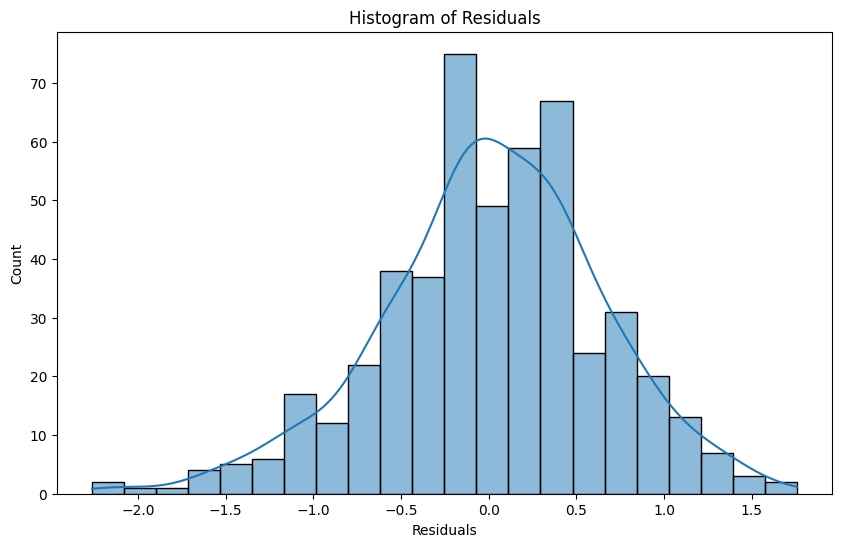

In [80]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

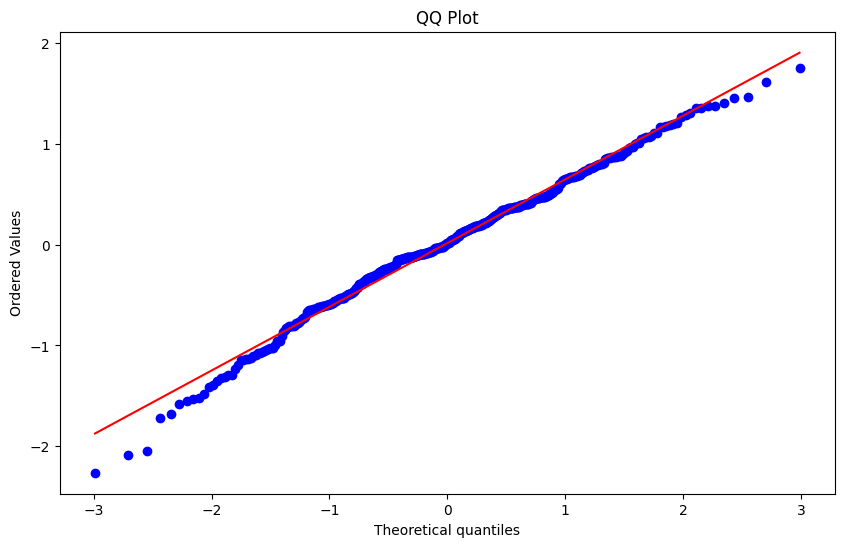

In [81]:
# QQ Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot')
plt.show()